This is file runs the main calculation for the flexible length TPS simulation. It requires the file `alanine_dipeptide_tps_equil.nc`, which is written in the notebook `alanine_dipeptide_tps_first_traj.ipynb`.

In this file, you will learn:
* how to set up and run a flexible length TPS simulation

NB: This is a long calculation. In practice, it would be best to export the Python from this notebook, remove the `live_visualization`, and run non-interactively on a computing node.

In [1]:
%matplotlib inline
import openpathsampling as paths

## Load engine, trajectory, and states from file

In [2]:
old_storage = paths.Storage("tps_nc_files/alanine_dipeptide_tps_equil.nc", "r")

In [3]:
engine = old_storage.engines[0]
alpha = old_storage.volumes.find('C_7eq')
beta = old_storage.volumes.find('alpha_R')
traj = old_storage.samplesets[len(old_storage.samplesets)-1][0].trajectory
phi = old_storage.cvs.find('phi')
psi = old_storage.cvs.find('psi')
template = old_storage.snapshots[0]

In [4]:
print engine.name

300K


## TPS

As always, the process for setting up a simulation is:

1. Create a `network`
2. Create a `move_scheme`
3. Set up `initial_conditions`
4. Create the `PathSampling` object and run it.

Since we already created all the input to these when we set up the first trajectory, we can load use the versions we loaded above.

In [5]:
network = paths.TPSNetwork(alpha, beta)

In [6]:
scheme = paths.OneWayShootingMoveScheme(network, selector=paths.UniformSelector(), engine=engine)

In [7]:
initial_conditions = scheme.initial_conditions_from_trajectories(traj)

In [8]:
sampler = paths.PathSampling(storage=paths.Storage("tps_nc_files/alanine_dipeptide_tps.nc", "w", template),
                             move_scheme=scheme,
                             sample_set=initial_conditions)
sampler.live_visualization = paths.LiveVisualization(network, phi, psi, [-3.14, 3.14], [-3.14, 3.14])

Note: 10000 steps will take a long time. If you just want to run a little bit, reduce this number.

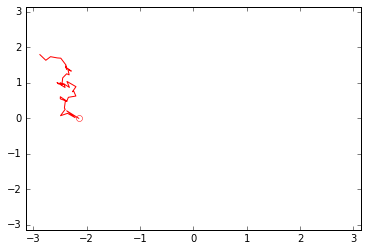

DONE! Completed 50 Monte Carlo cycles.


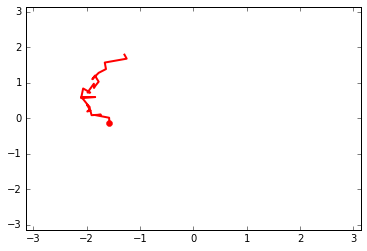

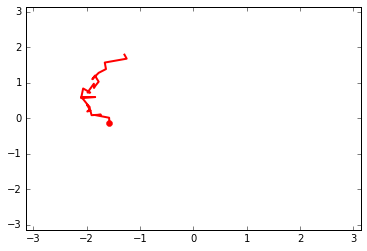

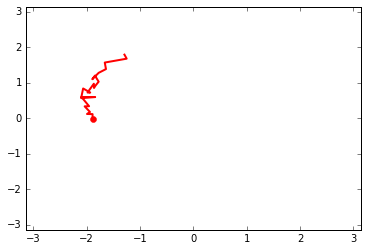

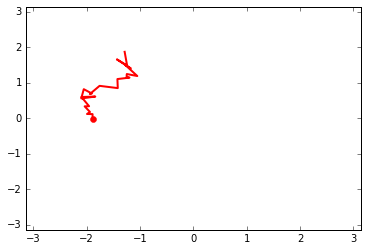

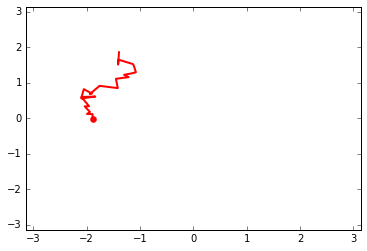

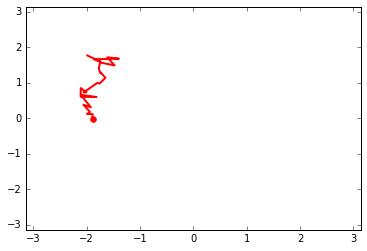

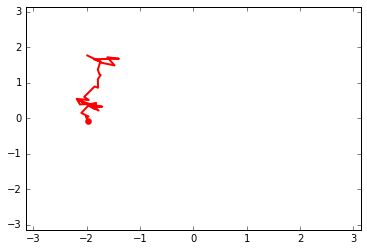

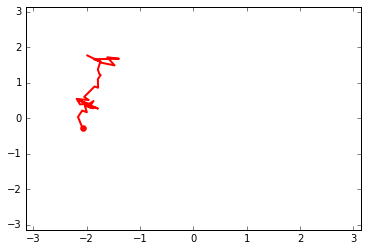

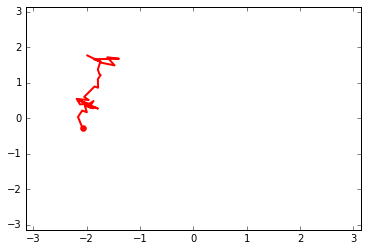

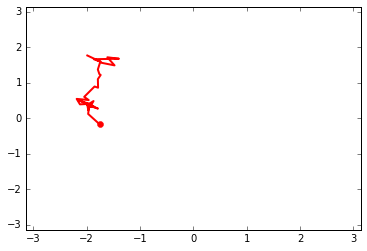

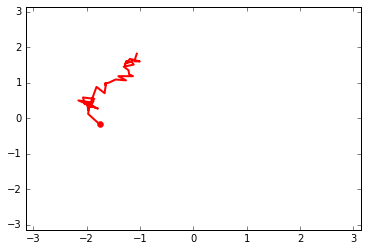

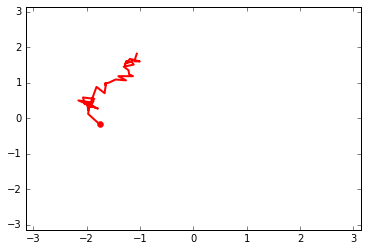

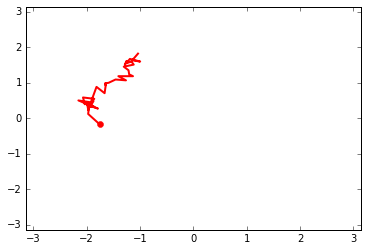

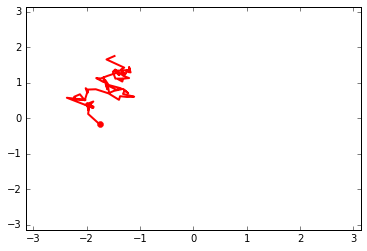

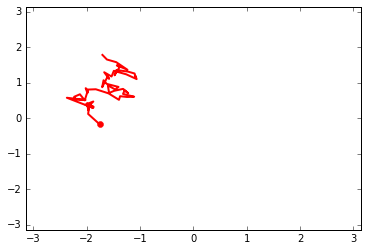

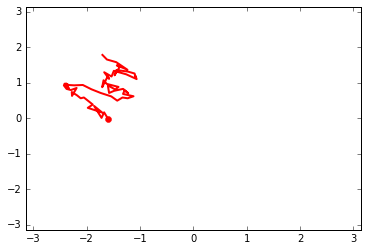

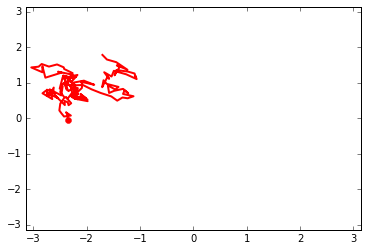

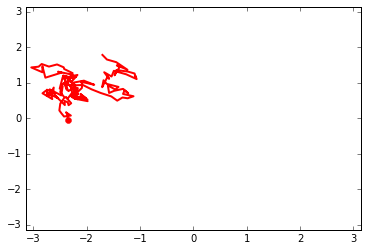

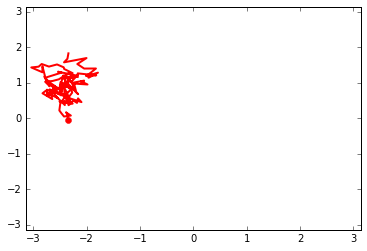

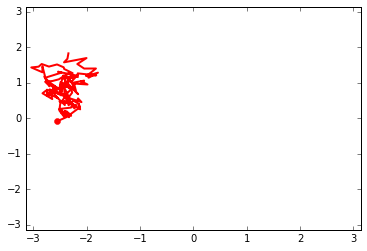

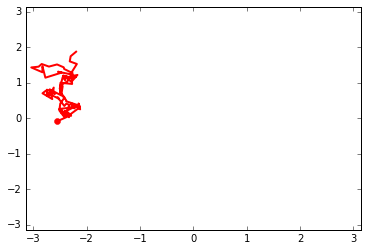

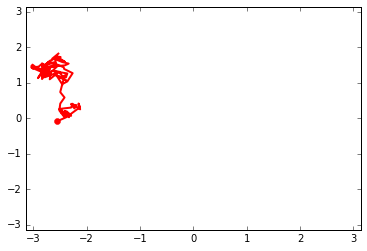

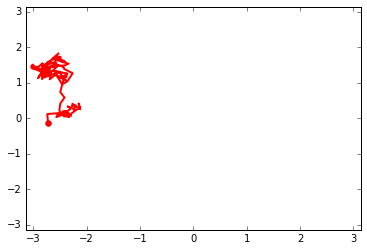

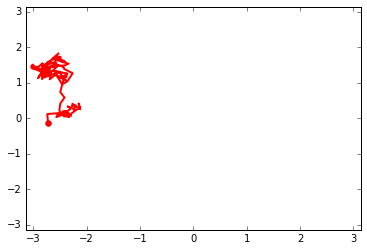

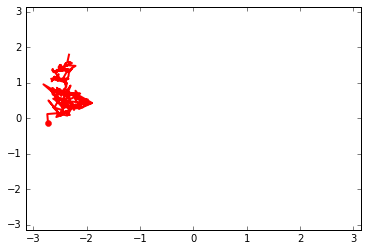

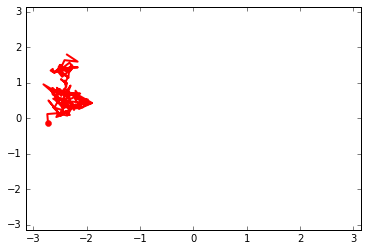

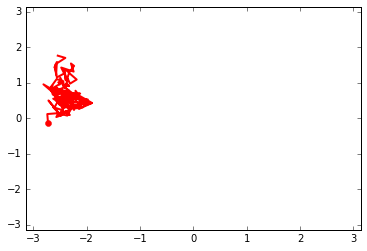

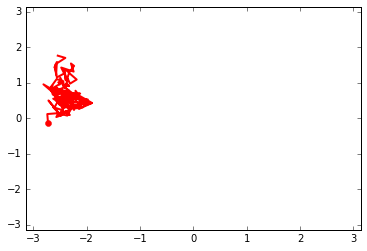

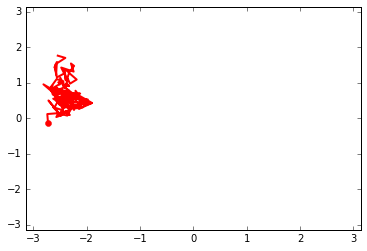

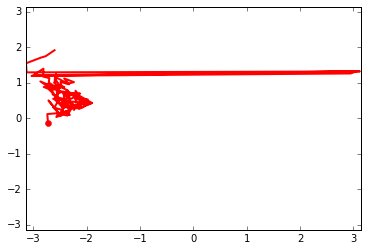

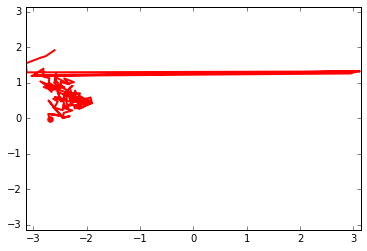

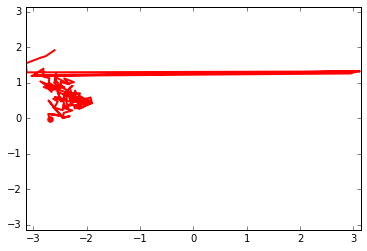

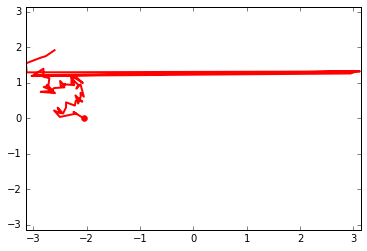

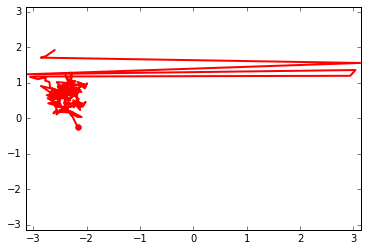

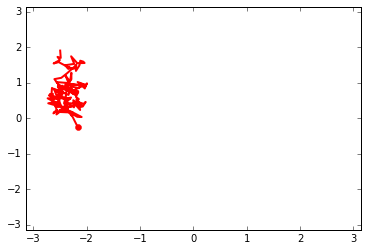

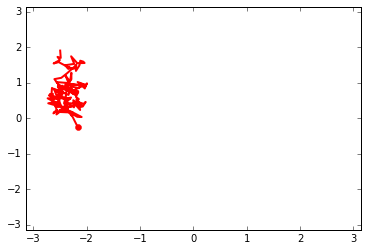

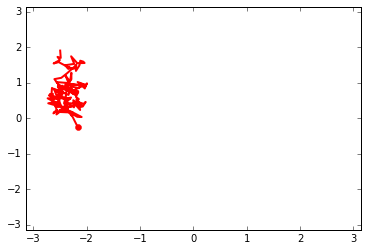

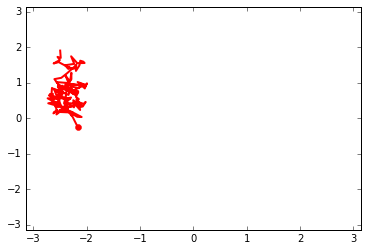

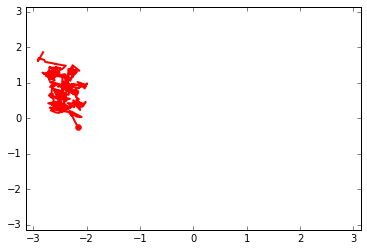

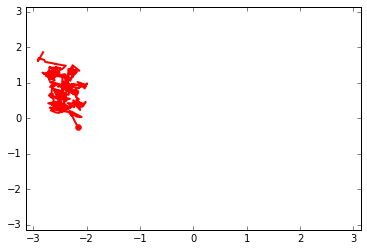

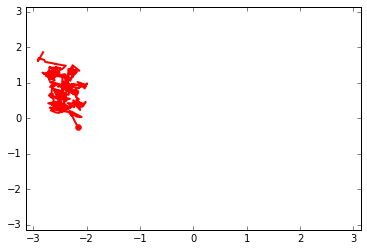

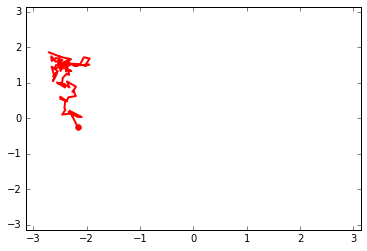

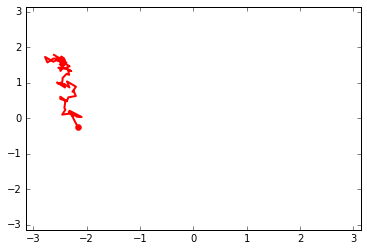

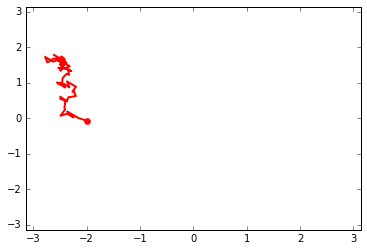

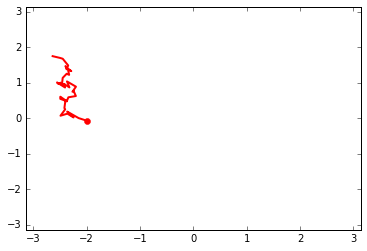

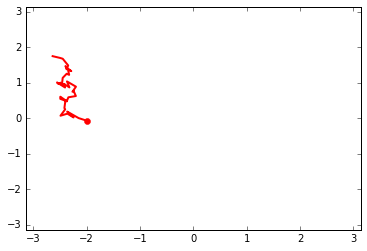

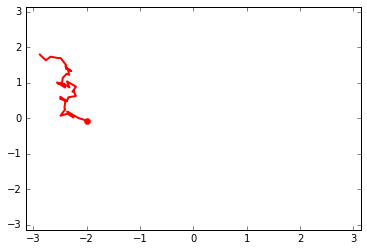

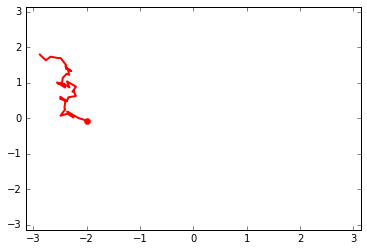

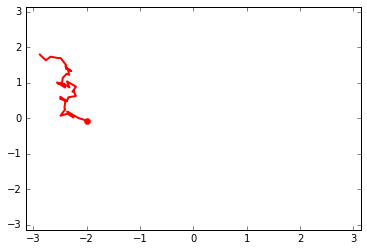

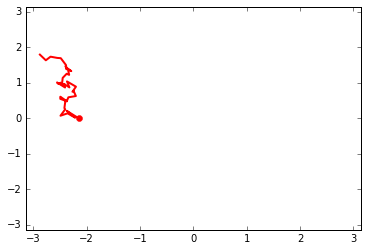

In [9]:
sampler.run(50)

With this done, you can go on to do the flexible-length parts of the analysis in `alanine_dipeptide_tps_analysis.ipynb`.